# Final Model Analysis
In this notebook, we perform analysis on the output of the final model. In particular, we analyse the model predictions of the official dev set.

In [44]:
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

with open("data/dev.txt", "r") as file:
    predictions = [int(line.strip()) for line in file]

df = pd.read_csv("data/dev.csv")
df["prediction"] = predictions

column_names = ["par_id", "art_id", "keyword", "country_code", "text", "score"]
raw_df = pd.read_csv("data/raw/dontpatronizeme.tsv", sep="\t", header=None, names=column_names)
raw_df = raw_df[["par_id", "score" ]]

df = df.merge(raw_df, on="par_id", how="left")

f1_score(df["label"], df["prediction"], pos_label=1)

0.6101694915254238

## Model Performance vs. Level of Patronising Content

We explore this by looking at the accuracy of the model for different strengths of PCL.

/tmp/ipykernel_1475292/1062809218.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_score = df.groupby('score').apply(lambda x: (x['label'] == x['prediction']).mean())


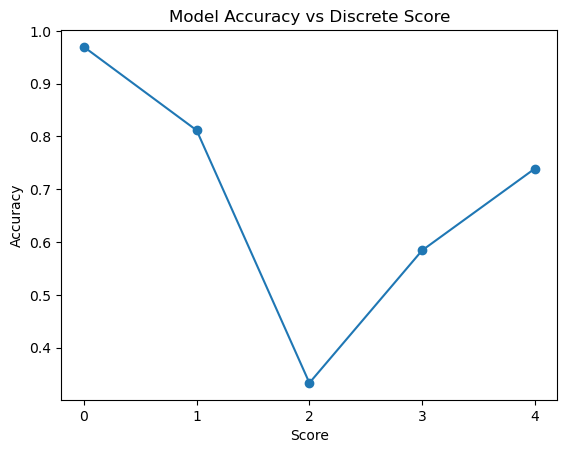

In [45]:
accuracy_per_score = df.groupby('score').apply(lambda x: (x['label'] == x['prediction']).mean())

plt.plot(accuracy_per_score.index, accuracy_per_score.values, marker='o')
plt.xlabel('Score')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Discrete Score')
plt.xticks(accuracy_per_score.index)  # Ensure all score values are shown on the x-axis
plt.show()

As expected, we find a V-shaped curve. The model is better at either extreme, identifying samples with no condescending language,
or strong condescending language, better than ambiguous examples. We find that in general, the model is better at identifying examples without PCL.

## Model Performance vs. Text Length

/tmp/ipykernel_1475292/4280525346.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f1_per_bin = df.groupby('length_bin').apply(calculate_f1)
/tmp/ipykernel_1475292/4280525346.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_per_bin = df.groupby('length_bin').apply(calculate_f1)


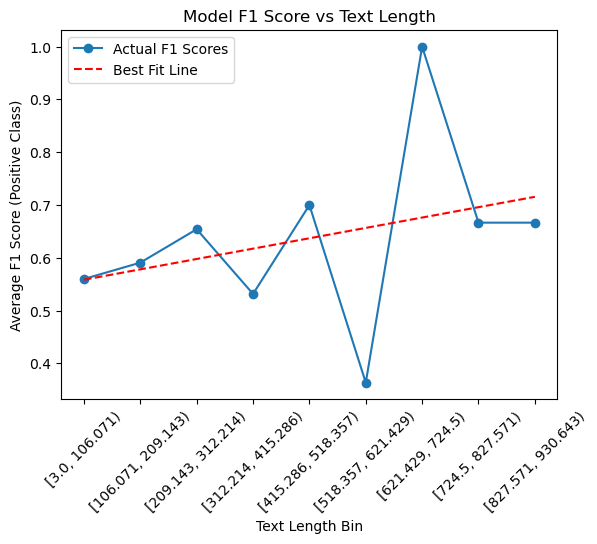

Pearson Correlation Coefficient: 0.3158297440924088
P Value: 0.4077071192168308


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr


# Sample dataframe
# df = pd.DataFrame({'label': ..., 'text': ..., 'prediction': ...})

# Calculate the length of each text sample
df['text_length'] = df['text'].apply(lambda x: len(str(x)))

# Define bins for text length (you can adjust the bin ranges based on the distribution of your text lengths)
bins = np.linspace(df['text_length'].min(), df['text_length'].max(), num=15)  # Adjust num to change bin count
df['length_bin'] = pd.cut(df['text_length'], bins=bins, right=False)  # right=False to include left edge, exclude right edge

# Function to calculate F1 score for the positive class (label == 1)
def calculate_f1(group):
    # We focus on the positive class (label == 1)
    positive_samples = group[group['label'] == 1]
    if len(positive_samples) == 0:
        return np.nan  # No positive samples in this bin
    y_true = group['label']
    y_pred = group['prediction']
    return f1_score(y_true, y_pred, pos_label=1)

# Calculate average F1 score for each bin
f1_per_bin = df.groupby('length_bin').apply(calculate_f1)

# Drop bins with NaN F1 scores (no positive samples)
f1_per_bin = f1_per_bin.dropna()

# Extract bin midpoints for linear regression
bin_midpoints = [bin.mid for bin in f1_per_bin.index]

# Reshape for linear regression
X = np.array(bin_midpoints).reshape(-1, 1)  # Independent variable: bin midpoints
y = f1_per_bin.values  # Dependent variable: F1 scores

# Perform linear regression
regressor = LinearRegression()
regressor.fit(X, y)

# Predict F1 scores using the regression model
y_pred = regressor.predict(X)

# Plot the F1 score against text length bins
plt.plot(f1_per_bin.index.astype(str), f1_per_bin.values, marker='o', label='Actual F1 Scores')

# Plot the line of best fit
plt.plot(f1_per_bin.index.astype(str), y_pred, color='red', linestyle='--', label='Best Fit Line')

plt.xlabel('Text Length Bin')
plt.ylabel('Average F1 Score (Positive Class)')
plt.title('Model F1 Score vs Text Length')
plt.xticks(rotation=45)
plt.legend()
plt.show()

correlation, p_value = pearsonr(bin_midpoints, f1_per_bin.values)

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P Value: {p_value}")

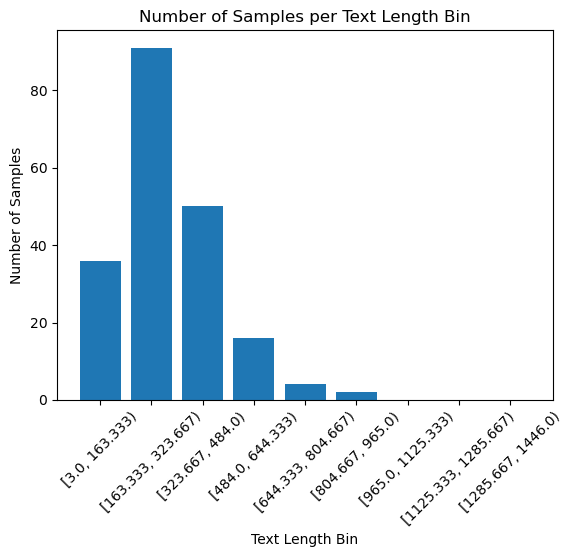

In [51]:
samples_per_bin = df[df["label"] == 1]['length_bin'].value_counts().sort_index()

# Plot the number of samples in each bin
plt.bar(samples_per_bin.index.astype(str), samples_per_bin.values)
plt.xlabel('Text Length Bin')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Text Length Bin')
plt.xticks(rotation=45)
plt.show()

## Model Performance vs. Keyword

keyword
disabled         0.608696
homeless         0.580645
hopeless         0.526316
immigrant        0.444444
in-need          0.784810
migrant          0.444444
poor-families    0.613333
refugee          0.545455
vulnerable       0.604651
women            0.521739
dtype: float64


/tmp/ipykernel_1475292/1851418605.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_per_keyword = df.groupby('keyword').apply(calculate_f1)


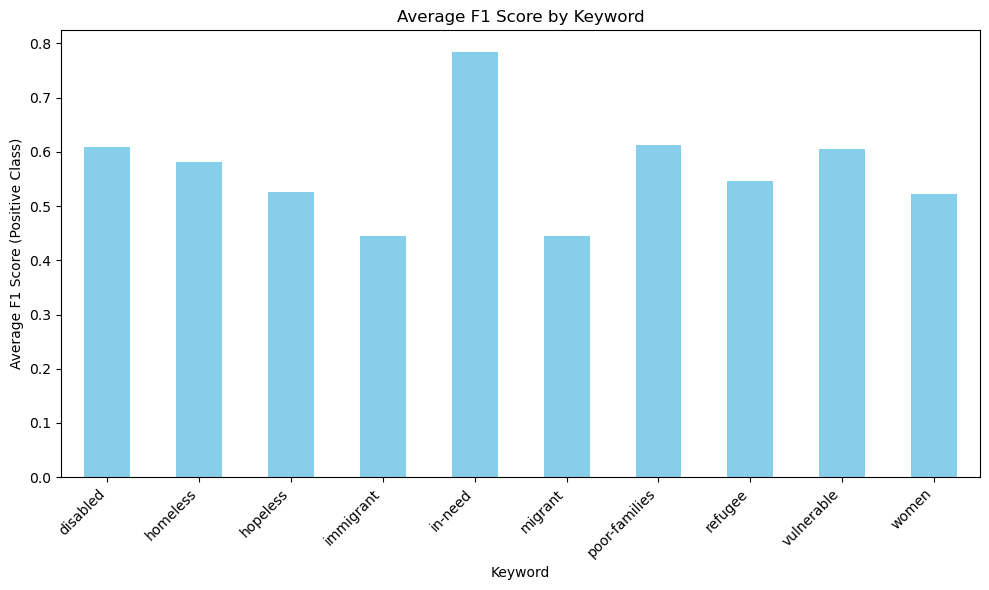

In [59]:
f1_per_keyword = df.groupby('keyword').apply(calculate_f1)

# Drop any NaN values in case there were no positive samples for a keyword group
f1_per_keyword = f1_per_keyword.dropna()

print(f1_per_keyword)

# Plot the average F1 score per keyword as a bar chart
plt.figure(figsize=(10, 6))
f1_per_keyword.plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Keyword')
plt.ylabel('Average F1 Score (Positive Class)')
plt.title('Average F1 Score by Keyword')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to avoid clipping of x-axis labels
plt.show()